<a href="https://colab.research.google.com/github/Raihandany/ML_Ganjil_2023/blob/main/Jobsheet10_GoogleColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB WORK WEEK 10

# Lab Work 1
RNN for Sentiment Analysis*


## **STEP 1 - Import Library**

In [5]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [6]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# **STEP 2 - Setup input pipeline**

In [7]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [8]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This is a sprawling (4 hours) remake of the Rider Haggard story, with the usual added female and an extraneous subplot with Russian soldiers seeking a "Stone of Power" buried along with the treasure of King Solomon. It\'s very well shot, giving a vivid sense of the wide open spaces of Africa, and very well acted. Patrick Swayze is an excellent Alan Quatermain, and Allison Doody is attractive as Elizabeth Maitland, who hires Quatermain to help rescue her father. Sidede Onyulo as Umbopa, Gavin Hood as McNabb and the leader of the Russian soldiers (not named in IMDb\'s listing) are also memorable. For all that Hollywood can\'t leave a good story alone when they adapt it, this one is well told and, except that it\'s too long, I enjoyed it. 6/10.'
 b"Ok, so, this is coming a few weeks late, but it is here. Mostly, this is because of statements of various negative natures. Starting with the technology. When Star Trek: TOS ran, special effect technology was extreamely low tec, and 

## **STEP 3 - Create a Text Encoder**

In [10]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [12]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,   4, ...,   0,   0,   0],
       [597,  38,  11, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0]])

In [13]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This is a sprawling (4 hours) remake of the Rider Haggard story, with the usual added female and an extraneous subplot with Russian soldiers seeking a "Stone of Power" buried along with the treasure of King Solomon. It\'s very well shot, giving a vivid sense of the wide open spaces of Africa, and very well acted. Patrick Swayze is an excellent Alan Quatermain, and Allison Doody is attractive as Elizabeth Maitland, who hires Quatermain to help rescue her father. Sidede Onyulo as Umbopa, Gavin Hood as McNabb and the leader of the Russian soldiers (not named in IMDb\'s listing) are also memorable. For all that Hollywood can\'t leave a good story alone when they adapt it, this one is well told and, except that it\'s too long, I enjoyed it. 6/10.'
Round-trip:  this is a [UNK] 4 hours remake of the [UNK] [UNK] story with the usual [UNK] female and an [UNK] [UNK] with [UNK] [UNK] [UNK] a [UNK] of power [UNK] along with the [UNK] of king [UNK] its very well shot giving a [UNK] sen

## **STEP 4 - Create Model**

In [14]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[0.00790585]


In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 87ms/step
[0.00790586]


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## **STEP 5 - Train Model**

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 49s 103ms/step - loss: 0.6478 - accuracy: 0.5605 - val_loss: 0.4829 - val_accuracy: 0.7411
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4392 - accuracy: 0.7879 - val_loss: 0.4015 - val_accuracy: 0.8177
Epoch 3/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3974 - accuracy: 0.8292 - val_loss: 0.3788 - val_accuracy: 0.8318
Epoch 4/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3490 - accuracy: 0.8492 - val_loss: 0.3708 - val_accuracy: 0.8490
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3301 - accuracy: 0.8593 - val_loss: 0.3426 - val_accuracy: 0.8484
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3193 - accuracy: 0.8642 - val_loss: 0.3370 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3118 - accuracy: 0.8684 - val_loss: 0.3282 - val_accuracy

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3188 - accuracy: 0.8615
Test Loss: 0.31884893774986267
Test Accuracy: 0.8614799976348877


(0.0, 0.6649174138903617)

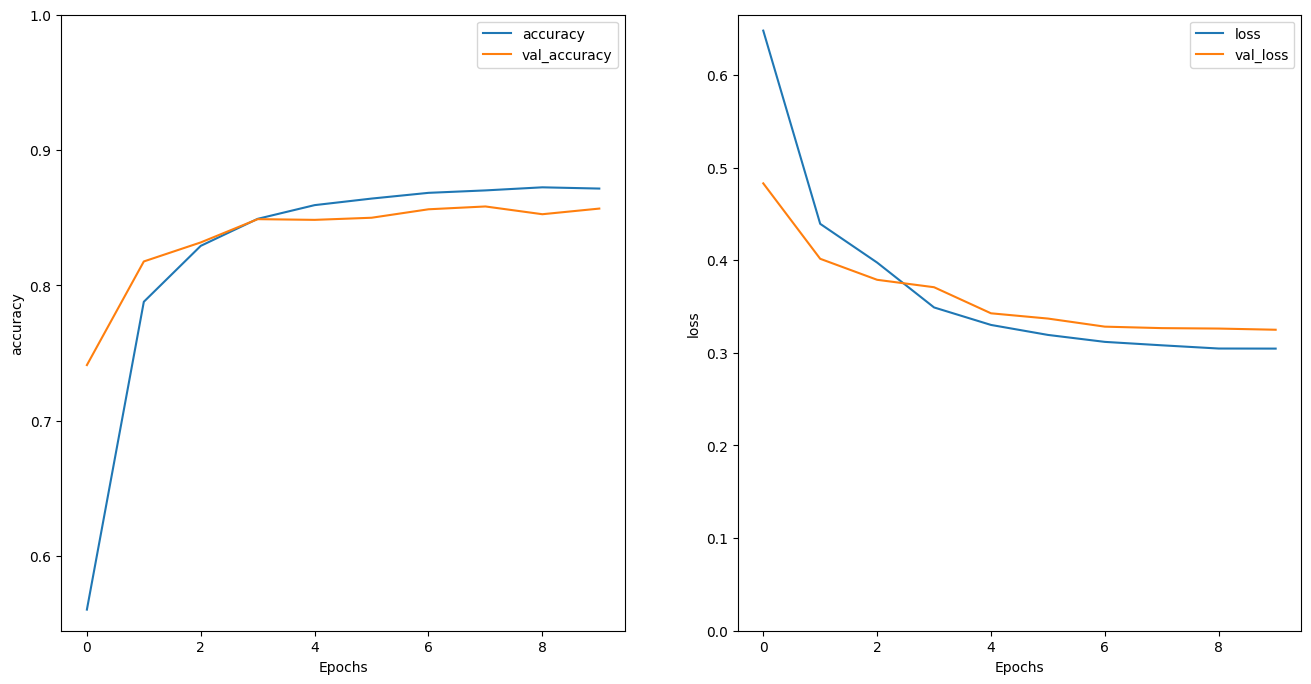

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 155ms/step - loss: 0.6081 - accuracy: 0.6077 - val_loss: 0.4231 - val_accuracy: 0.8031
Epoch 2/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3832 - accuracy: 0.8346 - val_loss: 0.3813 - val_accuracy: 0.8156
Epoch 3/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3347 - accuracy: 0.8562 - val_loss: 0.3511 - val_accuracy: 0.8260
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3232 - accuracy: 0.8626 - val_loss: 0.3241 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3118 - accuracy: 0.8680 - val_loss: 0.3188 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3075 - accuracy: 0.8696 - val_loss: 0.3203 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 47s 119ms/step - loss: 0.3052 - accuracy: 0.8705 - val_loss: 0.3163 - val_ac

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3128 - accuracy: 0.8579
Test Loss: 0.3127528727054596
Test Accuracy: 0.8578799962997437


In [27]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.8135315]]


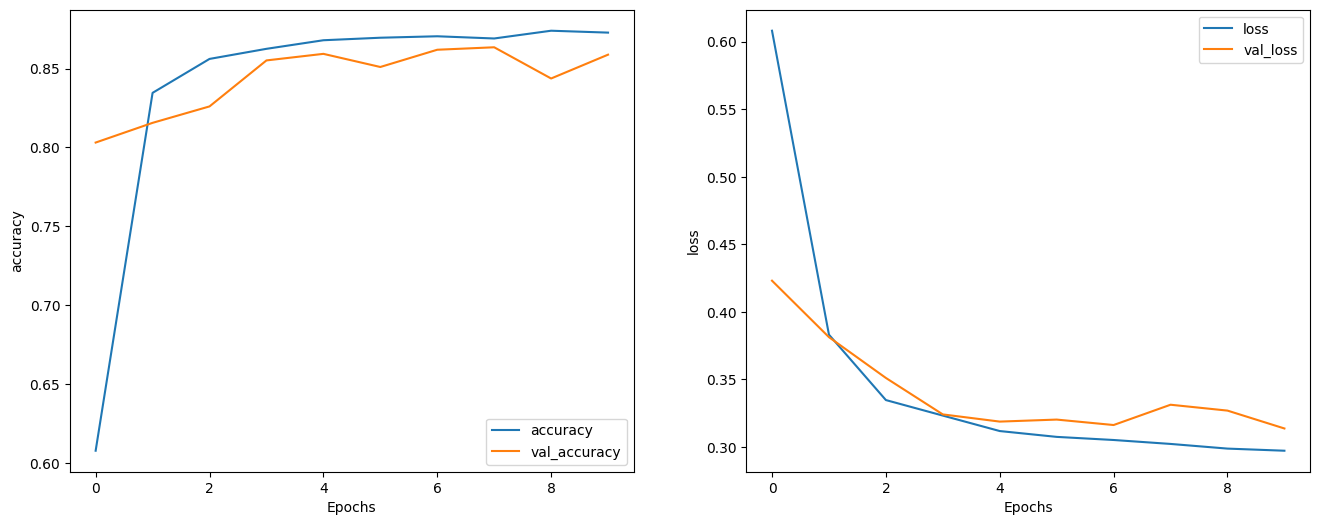

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

## **LAB WORK 2**

# **STEP 1 - Setup**

Import TenserFlow

In [29]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [30]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [31]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [32]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [33]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## **STEP 2 - Text Processing**

Vectorize Text

In [34]:
example_texts = ['abcdefg', 'xyz']
chars= tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [36]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [37]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [38]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [39]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [40]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

Prediction

Creating the Training Set and Target

In [41]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [42]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [43]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [44]:
seq_length = 100

In [45]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [46]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
    return tf.strings.reduce_join(ids_from_chars(ids), axis=-1).numpy()

In [47]:
for seq in sequences.take(5):
    print(text_from_ids(seq))

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [48]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [49]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [50]:
dataset = sequences.map(split_input_target)

In [51]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example))
  print("Target:", text_from_ids(target_example))

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Creating Batch Training

In [52]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# **STEP 3 - Creating Model**

In [53]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [54]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [55]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# **STEP 4 - Test and Model**

In [56]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [57]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [59]:
sampled_indices

array([59, 58, 51, 50, 57, 52, 46, 45, 37, 49,  5, 36, 15, 42, 32, 26, 21,
       60, 25, 60, 20, 38, 16, 10, 23, 42, 41, 45, 38, 45,  6, 14, 57, 61,
       65, 47, 11, 52, 64, 50, 54, 14,  9, 42, 55, 50, 11, 62, 37,  6, 58,
       58,  5, 37, 55, 33, 43, 35, 61, 36, 13, 43,  9, 21, 24, 42, 22, 60,
       16, 36, 38, 12,  7, 27, 61, 52,  1, 41, 27, 41, 32, 56,  8, 40, 15,
        4,  6, 49, 48, 35,  6, 63,  0, 29, 38, 13,  8, 35, 49, 56])

In [60]:
print("Input:\n", text_from_ids(input_example_batch[0]))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices))

Input:
 b"in, I'll make it my morn prayer\nTo have it added to the faults of mine,\nAnd nothing of your answer.\n"

Next Char Predictions:
 b"tslkrmgfXj&WBcSMHuLuGYC3JcbfYf'Arvzh:mykoA.cpk:wX'ss&XpTdVvW?d.HKcIuCWY;,Nvm\nbNbSq-aB$'jiV'x[UNK]PY?-Vjq"


# **STEP 5 - Train the Model**

Additional optimizer and loss function

In [61]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [62]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1895833, shape=(), dtype=float32)


In [63]:
tf.exp(example_batch_mean_loss).numpy()

65.995285

In [64]:
model.compile(optimizer='adam', loss=loss)

Configure Checkpoints

In [65]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Run the Training Process

In [66]:
EPOCHS=20

In [67]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 57ms/step - loss: 2.7323
Epoch 2/20
172/172 [==============================] - 12s 55ms/step - loss: 1.9893
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7141
Epoch 4/20
172/172 [==============================] - 11s 56ms/step - loss: 1.5525
Epoch 5/20
172/172 [==============================] - 11s 55ms/step - loss: 1.4527
Epoch 6/20
172/172 [==============================] - 12s 55ms/step - loss: 1.3840
Epoch 7/20
172/172 [==============================] - 11s 55ms/step - loss: 1.3306
Epoch 8/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2858
Epoch 9/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2444
Epoch 10/20
172/172 [==============================] - 12s 56ms/step - loss: 1.2049
Epoch 11/20
172/172 [==============================] - 12s 57ms/step - loss: 1.1644
Epoch 12/20
172/172 [==============================] - 12s 56ms/step - loss: 1.1245
E

### Step 6 - Generate Text

In [68]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [71]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

TypeError: ignored

In [70]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

NameError: ignored

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

**Export the Generator Model**

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

# Lab Assignment
The training procedure in practical 2 is a simple procedure that does not give you much control. This model uses 'teacher-forcing,' which prevents bad predictions from being fed back into the model, so the model never learns to recover from mistakes. So, after you've seen how to run the model manually, you'll implement a custom training loop. This provides a starting point if, for example, you want to implement curriculum learning to help stabilize the open-loop model's output. The most crucial part of the custom training loop is the training step function.
Use tf.GradientTape to track gradient values. You can learn more about this approach by reading the eager execution guide.

The procedure is:
1. Run the model and compute the loss using tf.GradientTape.
2. Calculate the updates and apply them to the model with the optimizer.

In [ ]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
          predictions = self(inputs, training=True)
          loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

The above code implements the train_step method according to Keras' train_step conventions. This is optional but allows you to modify the training step's behavior while still using Keras Model.compile and Model.fit methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

Or, if you want to have a deeper understanding, you can create your own custom training loop:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

# Method 1: Custom Training Loop with train_step

1. Use of train_step: In Method 1, you make use of Keras' train_step convention. You create an extended custom model class and add your own train_step method to override it. With this strategy, much of the training and optimization logic is handled by Keras; you just need to specify what happens at each training stage.

2. Keras Structure: The model is still usable and Method 1 continues to adhere to the Keras structure.assemble and simulate.suitable techniques to hone your model. This is more appropriate if you wish to slightly alter the training exercises.


# Method 2: Full Custom Training Loop

1. Complete Control: With Method 2, you are in complete control of the training procedure. Using the optimizer explicitly, you configure the training loop, compute gradients, calculate the loss, and apply model modifications. Additionally, you manage specifics like printing training statistics, preserving checkpoints, and managing the quantity of epochs.

2. Great Flexibility: Using Method 2, you may quickly put into practice highly customized training logic, such as learning rate scheduling, more intricate training techniques, and other custom reasoning.


# Conclusion:

- If you wish to train a text generation model with the least amount of alterations to the typical Keras training behavior, Method 1 is more appropriate. It's a more methodical and straightforward approach.
- If you require more control and want to personalize every aspect of the training process, Method 2 is better suited. It offers you the most flexibility to customize the training logic to suit your requirements.